In [1]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import shutil

print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Keras version: {keras.__version__}")
print(f"✓ OpenCV version: {cv2.__version__}")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("\n✓ All packages installed successfully!")


✓ TensorFlow version: 2.20.0
✓ Keras version: 3.12.0
✓ OpenCV version: 4.12.0
✓ NumPy version: 2.2.6
✓ GPU Available: False

✓ All packages installed successfully!


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow version: 2.20.0
GPU Available: False


In [8]:
DATA_DIR = '../data'
WITH_MASK_DIR = os.path.join(DATA_DIR, 'with_mask')
WITHOUT_MASK_DIR = os.path.join(DATA_DIR, 'without_mask')

# Split dataset paths (we'll create these)
SPLIT_DIR = '../data_split'
TRAIN_DIR = os.path.join(SPLIT_DIR, 'train')
VAL_DIR = os.path.join(SPLIT_DIR, 'validation')
TEST_DIR = os.path.join(SPLIT_DIR, 'test')

# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Split ratios
TRAIN_RATIO = 0.7  # 70% for training
VAL_RATIO = 0.15   # 15% for validation
TEST_RATIO = 0.15  # 15% for testing

# Create models directory
os.makedirs('../models', exist_ok=True)

print("✓ Paths configured successfully!")

✓ Paths configured successfully!


In [9]:
import os

# Check current directory
print("Current directory:", os.getcwd())
print("\nContents of current directory:")
print(os.listdir('.'))

# Check if data folder exists
if os.path.exists('data'):
    print("\n✓ 'data' folder exists")
    print("Contents of 'data' folder:")
    print(os.listdir('data'))
else:
    print("\n✗ 'data' folder NOT found")

Current directory: C:\Users\Nishant\OneDrive\MinorProject\notebooks

Contents of current directory:
['.ipynb_checkpoints', 'mask_detection_training.ipynb', 'models']

✗ 'data' folder NOT found



=== Original Dataset Statistics ===
With Mask: 3725 images
Without Mask: 3828 images
Total Images: 7553


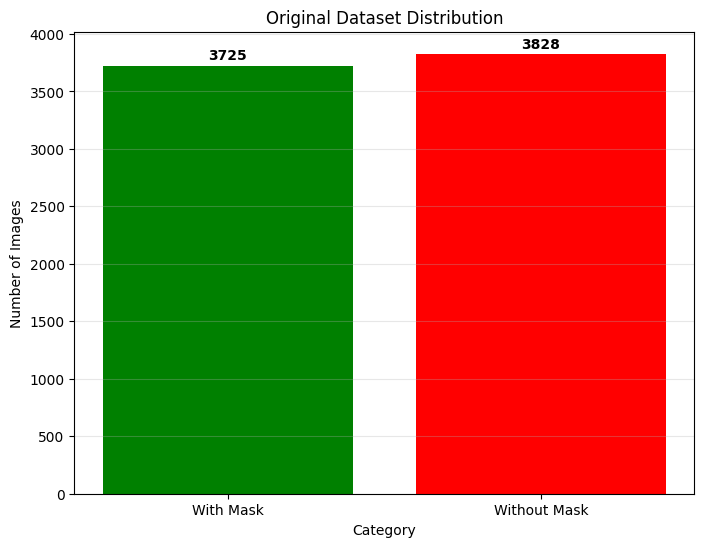

In [10]:
# Count images in each category
with_mask_count = len(os.listdir(WITH_MASK_DIR))
without_mask_count = len(os.listdir(WITHOUT_MASK_DIR))
total_images = with_mask_count + without_mask_count

print("\n=== Original Dataset Statistics ===")
print(f"With Mask: {with_mask_count} images")
print(f"Without Mask: {without_mask_count} images")
print(f"Total Images: {total_images}")

# Visualize distribution
plt.figure(figsize=(8, 6))
plt.bar(['With Mask', 'Without Mask'], [with_mask_count, without_mask_count], 
        color=['green', 'red'])
plt.title('Original Dataset Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Category')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate([with_mask_count, without_mask_count]):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.show()



=== Splitting Dataset ===
This may take a moment...

✓ Dataset split completed!

=== Split Statistics ===

Training Set:
  With Mask: 2607
  Without Mask: 2679
  Total: 5286

Validation Set:
  With Mask: 559
  Without Mask: 574
  Total: 1133

Test Set:
  With Mask: 559
  Without Mask: 575
  Total: 1134


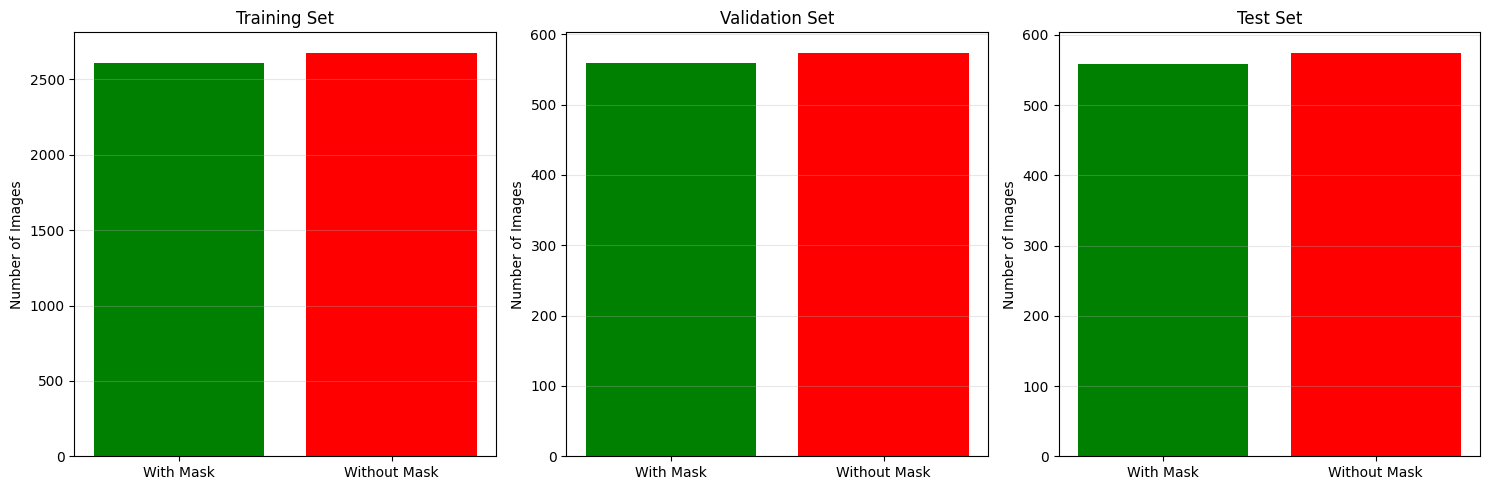

In [12]:
def split_dataset(source_dir, dest_base_dir, category_name, train_ratio, val_ratio, test_ratio):
    """Split a category into train/val/test sets"""
    
    # Get all image files
    all_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Split the data - first split into train and temp (val+test)
    train_files, temp_files = train_test_split(
        all_files, 
        train_size=train_ratio,  # Use ratio directly (0.7)
        random_state=42
    )
    
    # Then split temp into validation and test
    # Calculate the ratio of validation in the remaining data
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    
    val_files, test_files = train_test_split(
        temp_files, 
        train_size=val_ratio_adjusted,  # Use adjusted ratio (0.5)
        random_state=42
    )
    
    # Create directories
    train_cat_dir = os.path.join(dest_base_dir, 'train', category_name)
    val_cat_dir = os.path.join(dest_base_dir, 'validation', category_name)
    test_cat_dir = os.path.join(dest_base_dir, 'test', category_name)
    
    os.makedirs(train_cat_dir, exist_ok=True)
    os.makedirs(val_cat_dir, exist_ok=True)
    os.makedirs(test_cat_dir, exist_ok=True)
    
    # Copy files to respective directories
    for file in train_files:
        shutil.copy2(os.path.join(source_dir, file), os.path.join(train_cat_dir, file))
    
    for file in val_files:
        shutil.copy2(os.path.join(source_dir, file), os.path.join(val_cat_dir, file))
    
    for file in test_files:
        shutil.copy2(os.path.join(source_dir, file), os.path.join(test_cat_dir, file))
    
    return len(train_files), len(val_files), len(test_files)

print("\n=== Splitting Dataset ===")
print("This may take a moment...")

# Split with_mask images
with_mask_train, with_mask_val, with_mask_test = split_dataset(
    WITH_MASK_DIR, SPLIT_DIR, 'with_mask', TRAIN_RATIO, VAL_RATIO, TEST_RATIO
)

# Split without_mask images
without_mask_train, without_mask_val, without_mask_test = split_dataset(
    WITHOUT_MASK_DIR, SPLIT_DIR, 'without_mask', TRAIN_RATIO, VAL_RATIO, TEST_RATIO
)

print("\n✓ Dataset split completed!")
print("\n=== Split Statistics ===")
print(f"\nTraining Set:")
print(f"  With Mask: {with_mask_train}")
print(f"  Without Mask: {without_mask_train}")
print(f"  Total: {with_mask_train + without_mask_train}")

print(f"\nValidation Set:")
print(f"  With Mask: {with_mask_val}")
print(f"  Without Mask: {without_mask_val}")
print(f"  Total: {with_mask_val + without_mask_val}")

print(f"\nTest Set:")
print(f"  With Mask: {with_mask_test}")
print(f"  Without Mask: {without_mask_test}")
print(f"  Total: {with_mask_test + without_mask_test}")

# Visualize split distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

splits = ['Training', 'Validation', 'Test']
with_mask_counts = [with_mask_train, with_mask_val, with_mask_test]
without_mask_counts = [without_mask_train, without_mask_val, without_mask_test]

for i, (split_name, with_count, without_count) in enumerate(zip(splits, with_mask_counts, without_mask_counts)):
    axes[i].bar(['With Mask', 'Without Mask'], [with_count, without_count], color=['green', 'red'])
    axes[i].set_title(f'{split_name} Set')
    axes[i].set_ylabel('Number of Images')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


=== Sample Training Images ===


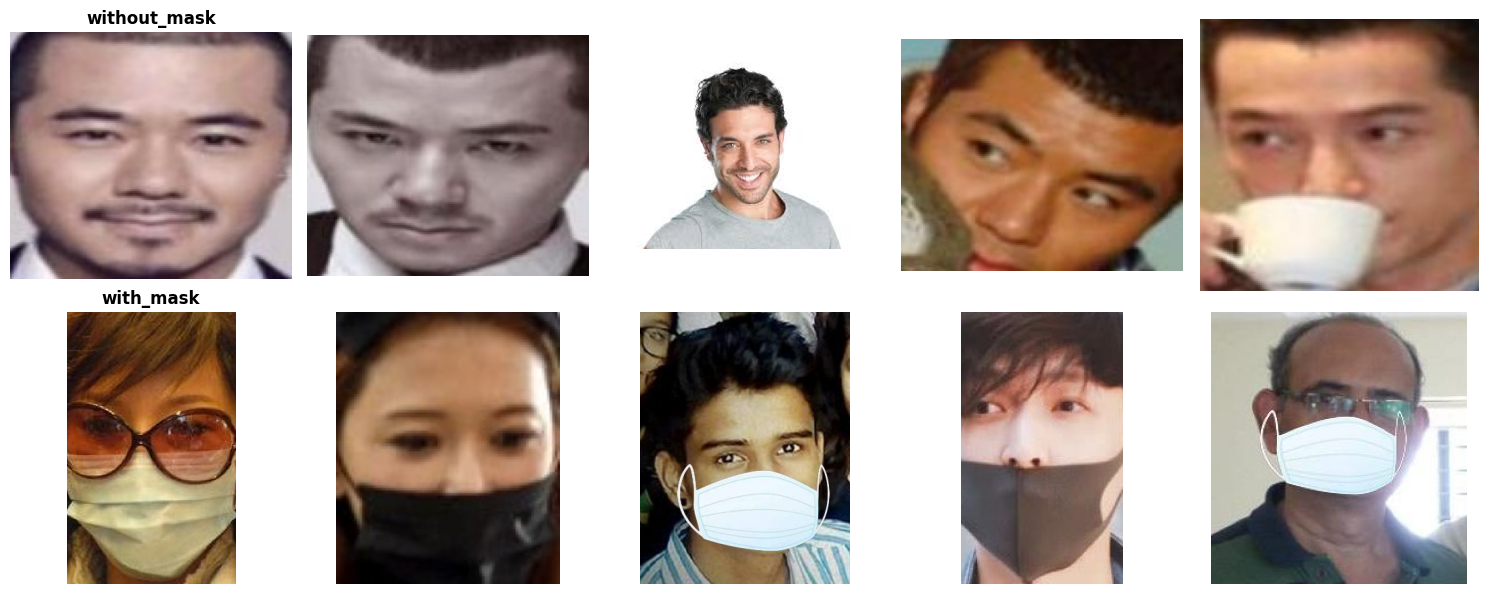

In [13]:
# ============================================
# STEP 5: Visualize Sample Images
# ============================================

def plot_sample_images(directory, num_samples=5):
    categories = os.listdir(directory)
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 6))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        images = os.listdir(category_path)[:num_samples]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)
            
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\n=== Sample Training Images ===")
plot_sample_images(TRAIN_DIR)

In [14]:
# ============================================
# STEP 6: Data Preprocessing & Augmentation
# ============================================

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n=== Data Generators Created ===")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 5286 images belonging to 2 classes.
Found 1133 images belonging to 2 classes.
Found 1134 images belonging to 2 classes.

=== Data Generators Created ===
Training samples: 5286
Validation samples: 1133
Test samples: 1134
Class indices: {'with_mask': 0, 'without_mask': 1}


In [15]:
# ============================================
# STEP 7: Build Model (Transfer Learning)
# ============================================

def create_model():
    # Load pre-trained MobileNetV2 model
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create new model
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')  # 2 classes: with_mask, without_mask
    ])
    
    return model

# Create model
model = create_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\n=== Model Architecture ===")
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

=== Model Architecture ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,430,338 (9.27 MB)

 Trainable params: 172,354 (673.26 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# ============================================
# STEP 8: Setup Callbacks
# ============================================

# Model checkpoint - save best model
checkpoint = ModelCheckpoint(
    '../models/best_mask_detector.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping - stop if no improvement
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]

print("✓ Callbacks configured")

✓ Callbacks configured


In [17]:
# ============================================
# STEP 9: Train Model
# ============================================

print("\n Starting Training ")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")


 Starting Training 
Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7271 - loss: 0.5449
Epoch 1: val_accuracy improved from None to 0.97087, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.8294 - loss: 0.3845 - val_accuracy: 0.9709 - val_loss: 0.1026 - learning_rate: 1.0000e-04
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9332 - loss: 0.1814
Epoch 2: val_accuracy improved from 0.97087 to 0.98058, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9438 - loss: 0.1551 - val_accuracy: 0.9806 - val_loss: 0.0618 - learning_rate: 1.0000e-04
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9547 - loss: 0.1208
Epoch 3: val_accuracy did not improve from 0.98058
166/166 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9552 - loss: 0.1137 - val_accuracy: 0.9797 - val_loss: 0.0578 - learning_rate: 1.0000e-04
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.9626 - loss: 0.0971
Epoch 4: val_accuracy improved from 0.98058 to 0.98323, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9675 - loss: 0.0911 - val_accuracy: 0.9832 - val_loss: 0.0490 - learning_rate: 1.0000e-04
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9692 - loss: 0.0852
Epoch 5: val_accuracy improved from 0.98323 to 0.98411, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9695 - loss: 0.0845 - val_accuracy: 0.9841 - val_loss: 0.0441 - learning_rate: 1.0000e-04
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.9722 - loss: 0.0849
Epoch 6: val_accuracy improved from 0.98411 to 0.98676, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9752 - loss: 0.0795 - val_accuracy: 0.9868 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.9767 - loss: 0.0694
Epoch 7: val_accuracy did not improve from 0.98676
166/166 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9765 - loss: 0.0698 - val_accuracy: 0.9868 - val_loss: 0.0419 - learning_rate: 1.0000e-04
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.9810 - loss: 0.0562
Epoch 8: val_accuracy improved from 0.98676 to 0.98764, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9803 - loss: 0.0587 - val_accuracy: 0.9876 - val_loss: 0.0394 - learning_rate: 1.0000e-04
Epoch 9/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9800 - loss: 0.0648
Epoch 9: val_accuracy did not improve from 0.98764
166/166 ━━━━━━━━━━━━━━━━━━━━ 165s 993ms/step - accuracy: 0.9798 - loss: 0.0621 - val_accuracy: 0.9876 - val_loss: 0.0364 - learning_rate: 1.0000e-04
Epoch 10/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.9765 - loss: 0.0648
Epoch 10: val_accuracy did not improve from 0.98764
166/166 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9815 - loss: 0.0575 - val_accuracy: 0.9868 - val_loss: 0.0365 - learning_rate: 1.0000e-04
Epoch 11/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9788 - loss: 0.0608
Epoch 11: val_accuracy improved from 0.98764 to 0.98853, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 198s 987ms/step - accuracy: 0.9799 - loss: 0.0582 - val_accuracy: 0.9885 - val_loss: 0.0364 - learning_rate: 1.0000e-04
Epoch 12/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.9819 - loss: 0.0505
Epoch 12: val_accuracy did not improve from 0.98853

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
166/166 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9835 - loss: 0.0472 - val_accuracy: 0.9876 - val_loss: 0.0366 - learning_rate: 1.0000e-04
Epoch 13/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9842 - loss: 0.0487
Epoch 13: val_accuracy improved from 0.98853 to 0.98941, saving model to ../models/best_mask_detector.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9828 - loss: 0.0515 - val_accuracy: 0.9894 - val_loss: 0.0341 - learning_rate: 5.0000e-05
Epoch 14/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.9823 - loss: 0.0487
Epoch 14: val_accuracy did not improve from 0.98941
166/166 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9828 - loss: 0.0525 - val_accuracy: 0.9876 - val_loss: 0.0340 - learning_rate: 5.0000e-05
Epoch 15/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.9808 - loss: 0.0489
Epoch 15: val_accuracy did not improve from 0.98941
166/166 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9818 - loss: 0.0490 - val_accuracy: 0.9885 - val_loss: 0.0323 - learning_rate: 5.0000e-05
Epoch 16/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.9823 - loss: 0.0536
Epoch 16: val_accuracy did not improve from 0.98941
166/166 ━━━━━━━━━━━━━━━━━━━━ 165s 995ms/step - accuracy: 0.9822 - loss: 0.0543 - val_accuracy: 0.9885 - val_loss: 0.0323 - learning_rate: 5

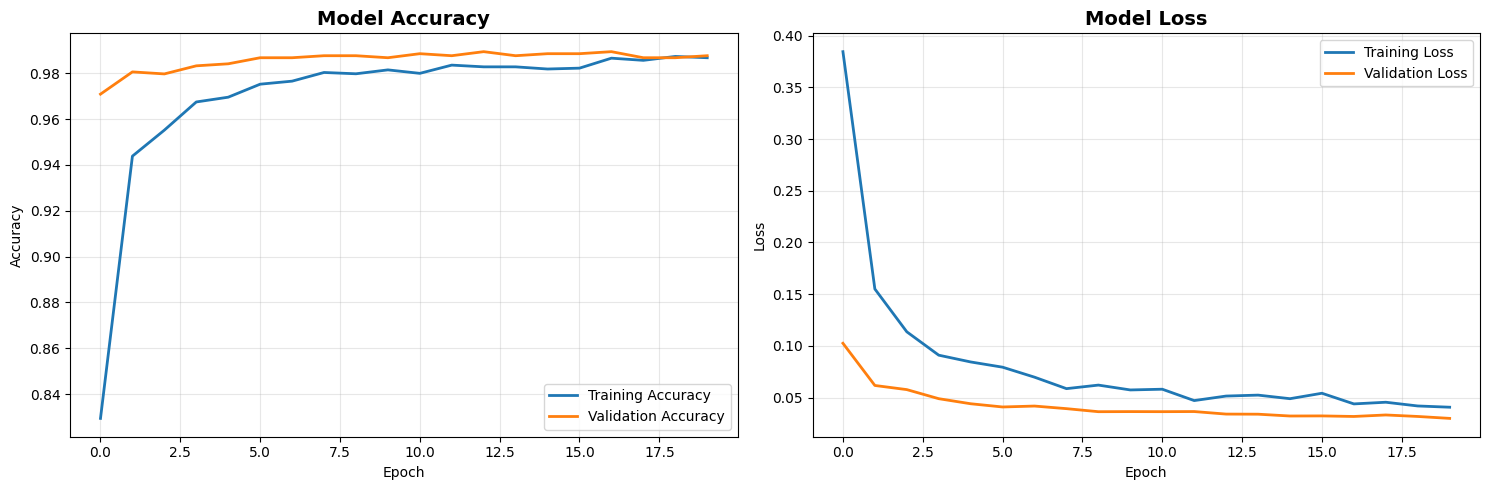

In [18]:
# ============================================
# STEP 10: Plot Training History
# ============================================

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)

In [19]:
# ============================================
# STEP 11: Evaluate on Test Set
# ============================================

print("\nEvaluating on Test Set ")

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Class names
class_names = list(test_generator.class_indices.keys())

# Classification report
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))


Evaluating on Test Set 
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9850 - loss: 0.0346

Test Accuracy: 98.50%
Test Loss: 0.0346
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 844ms/step

=== Classification Report ===
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       559
without_mask       0.99      0.98      0.99       575

    accuracy                           0.99      1134
   macro avg       0.98      0.99      0.99      1134
weighted avg       0.99      0.99      0.99      1134



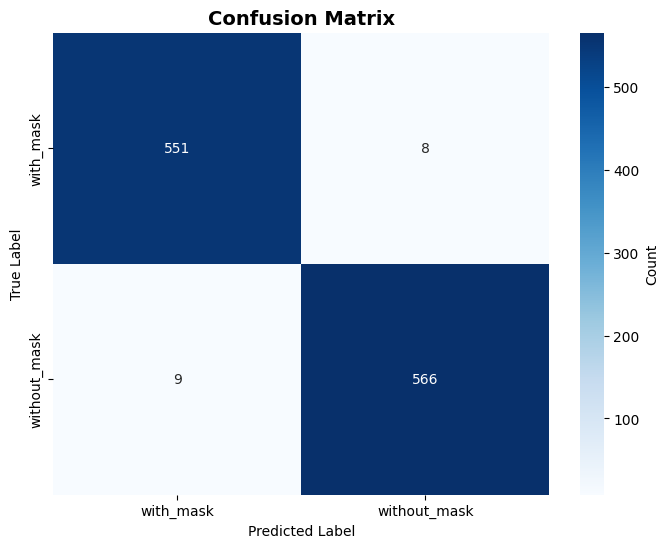


=== Overall Metrics ===
Accuracy:  98.50%
Precision: 98.50%
Recall:    98.50%
F1-Score:  98.50%


In [20]:
# ============================================
# STEP 12: Confusion Matrix
# ============================================

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('../models/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n=== Overall Metrics ===")
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1-Score:  {f1 * 100:.2f}%")

In [21]:
# ============================================
# STEP 13: Save Final Model
# ============================================

# Save model in different formats
model.save('../models/face_mask_detector.h5')
model.save('../models/face_mask_detector.keras')

# Save class indices
import json
with open('../models/class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

print("\n✓ Model saved successfully!")
print("  - ../models/face_mask_detector.h5")
print("  - ../models/face_mask_detector.keras")
print("  - ../models/best_mask_detector.h5")
print("  - ../models/class_indices.json")
print("  - ../models/training_history.png")
print("  - ../models/confusion_matrix.png")


✓ Model saved successfully!
  - ../models/face_mask_detector.h5
  - ../models/face_mask_detector.keras
  - ../models/best_mask_detector.h5
  - ../models/class_indices.json
  - ../models/training_history.png
  - ../models/confusion_matrix.png



=== Testing on Sample Images ===


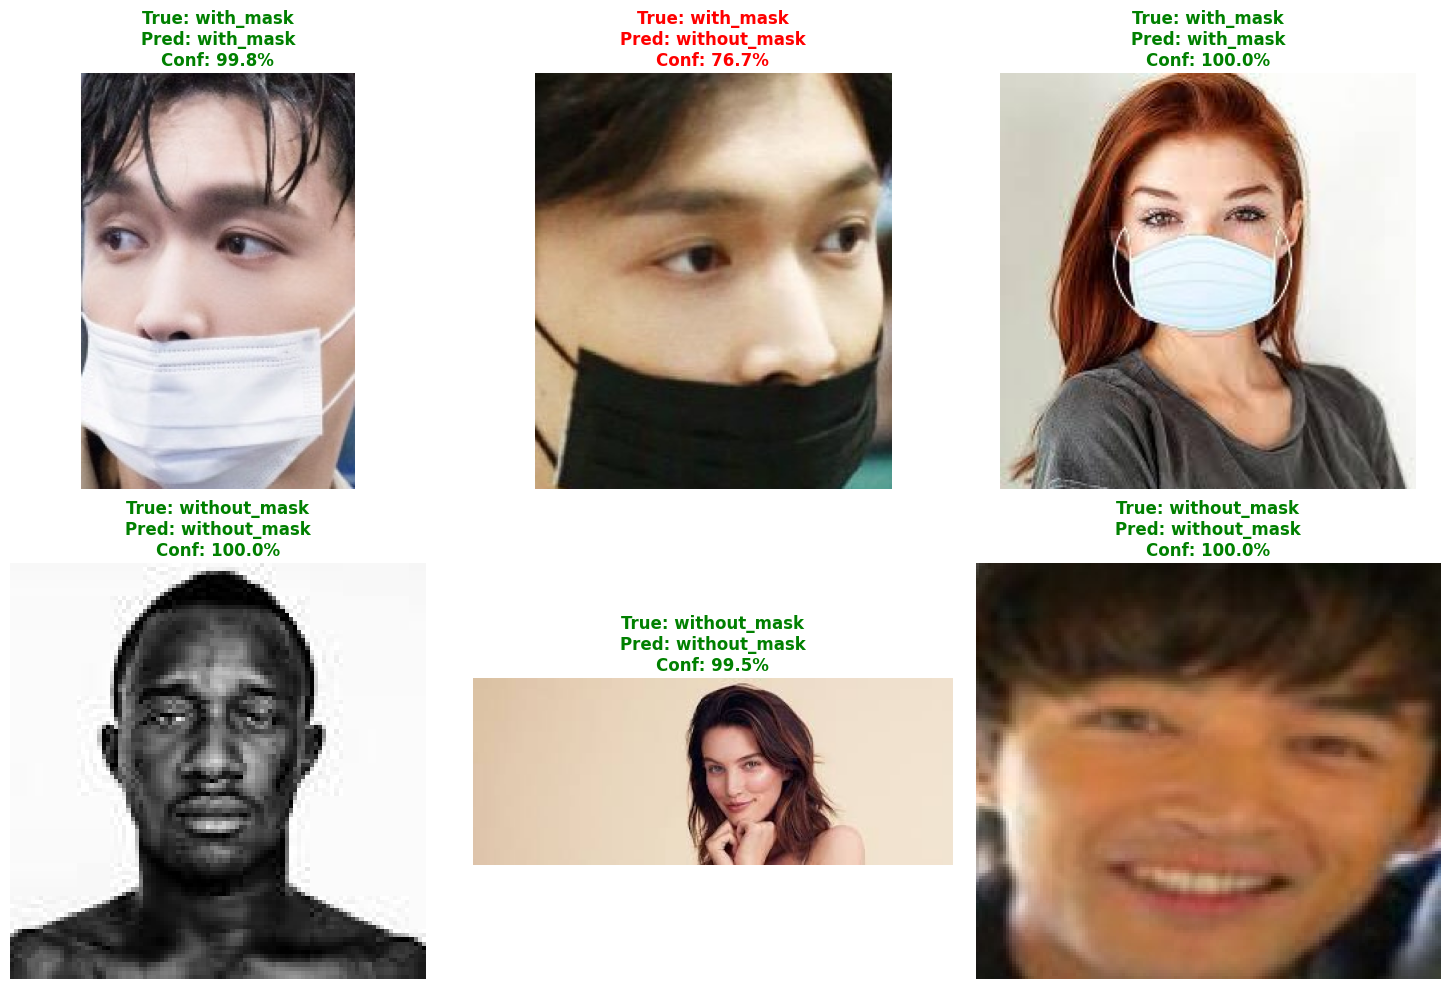


✓ Training pipeline completed successfully!

Next Steps:
1. Check the '../models/' folder for saved models
2. Review training plots and metrics
3. Ready to create deployment application!


In [22]:
# ============================================
# STEP 14: Test on Sample Images
# ============================================

def predict_single_image(img_path, model):
    """Predict mask on a single image"""
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array, verbose=0)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx] * 100
    
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_labels[class_idx]
    
    return predicted_class, confidence

# Test on sample images from both classes
print("\n=== Testing on Sample Images ===")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(TEST_DIR, class_name)
    sample_images = os.listdir(class_dir)[:3]
    
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        
        predicted_class, confidence = predict_single_image(img_path, model)
        
        # Determine if prediction is correct
        is_correct = predicted_class == class_name
        border_color = 'green' if is_correct else 'red'
        
        axes[class_idx, i].imshow(img)
        axes[class_idx, i].axis('off')
        axes[class_idx, i].set_title(
            f'True: {class_name}\nPred: {predicted_class}\nConf: {confidence:.1f}%',
            color=border_color,
            fontweight='bold'
        )
        
        # Add border
        for spine in axes[class_idx, i].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)

plt.tight_layout()
plt.savefig('../models/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("✓ Training pipeline completed successfully!")
print("="*50)
print("\nNext Steps:")
print("1. Check the '../models/' folder for saved models")
print("2. Review training plots and metrics")
print("3. Ready to create deployment application!")